# Running KRAKEN Ocean Acoustic Model

In [5]:
%load_ext autoreload
%autoreload
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, Path.cwd())
from tritonoa.plotting import plot_SSP, plot_TL_2d
from tritonoa.signal.sp import normalize_pressure
from tritonoa.ssp import munk_ssp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Using the `KrakenEnvironment` and `KrakenModel` interface

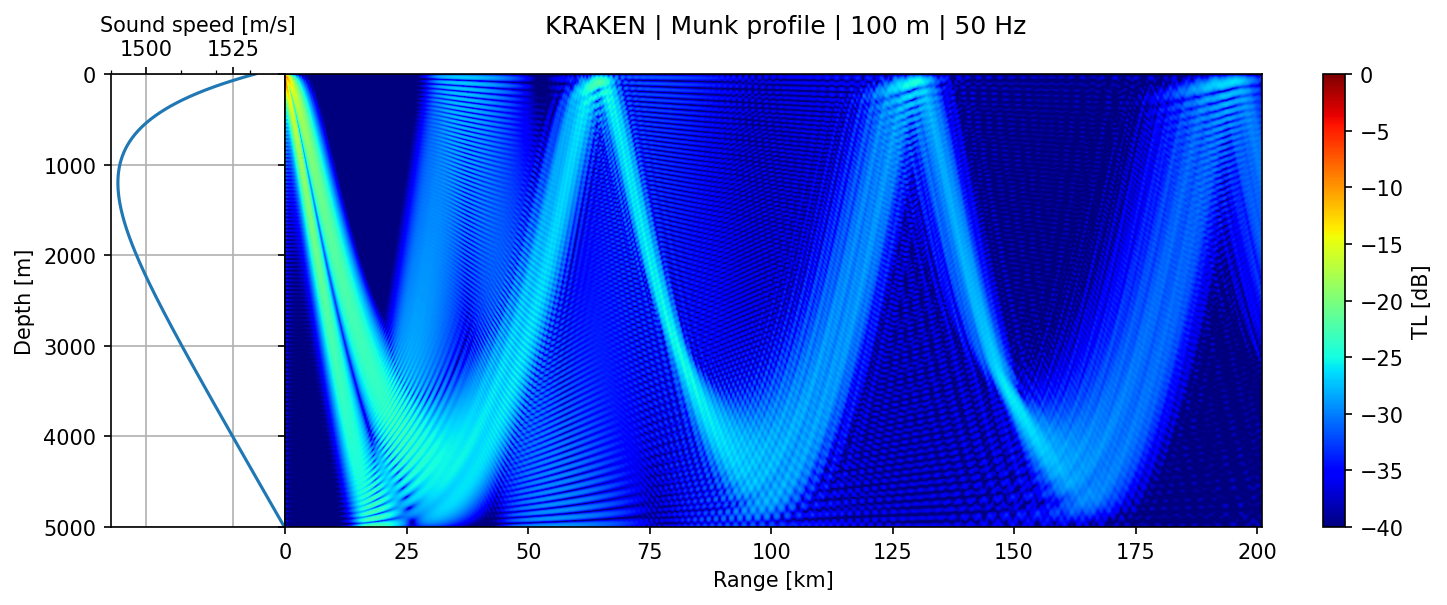

In [9]:
from tritonoa.at.env.array import Receiver, Source
from tritonoa.at.env.halfspace import Bottom, Top
from tritonoa.at.models.kraken.kraken import KrakenEnvironment, KrakenModel
from tritonoa.at.env.ssp import SSPLayer, SoundSpeedProfileAT

title = "Munk"
model = "KRAKEN"

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

top = Top()

ssp = SoundSpeedProfileAT(z=z_data, c_p=c_data)
layer = SSPLayer(ssp)
layers = [layer]

bottom = Bottom(opt="A", z=layer.z_max, c_p=1600, rho=1.8, a_p=0.8)

src_z = 100
source = Source(src_z)
zvec = np.arange(0, layer.z_max+1, 5)
rvec = np.arange(0, 201, 10/1e3)
                                                            
receiver = Receiver(z=zvec, r=rvec)

freq = 50
clow = 1500
chigh = 1600

kraken_env = KrakenEnvironment(
    title,
    freq,
    layers,
    top,
    bottom,
    tmpdir="tmp",
    source=source,
    receiver=receiver,
    clow=clow,
    chigh=chigh
)

kraken_model = KrakenModel(kraken_env)
kraken_model.run(model_name=model, fldflag=True)
p = kraken_model.modes.p
p = normalize_pressure(p, log=True)

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(12, 4), dpi=150)

ax = plot_SSP(
    z_data,
    c_data,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax = plot_TL_2d(
    p,
    z=zvec,
    r=np.array(np.concatenate((np.array([0]), rvec))),
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"{model} | {title} profile | {src_z} m | {freq} Hz")
plt.show()

### Using the `runner` interface

When using TritonOA with the `runner` interface, all of the model parameters are stored in a dictionary and passed to the runner function. This interface is a convenient method to run the model and obtain the predicted complex acoustic pressure at the receiver array.

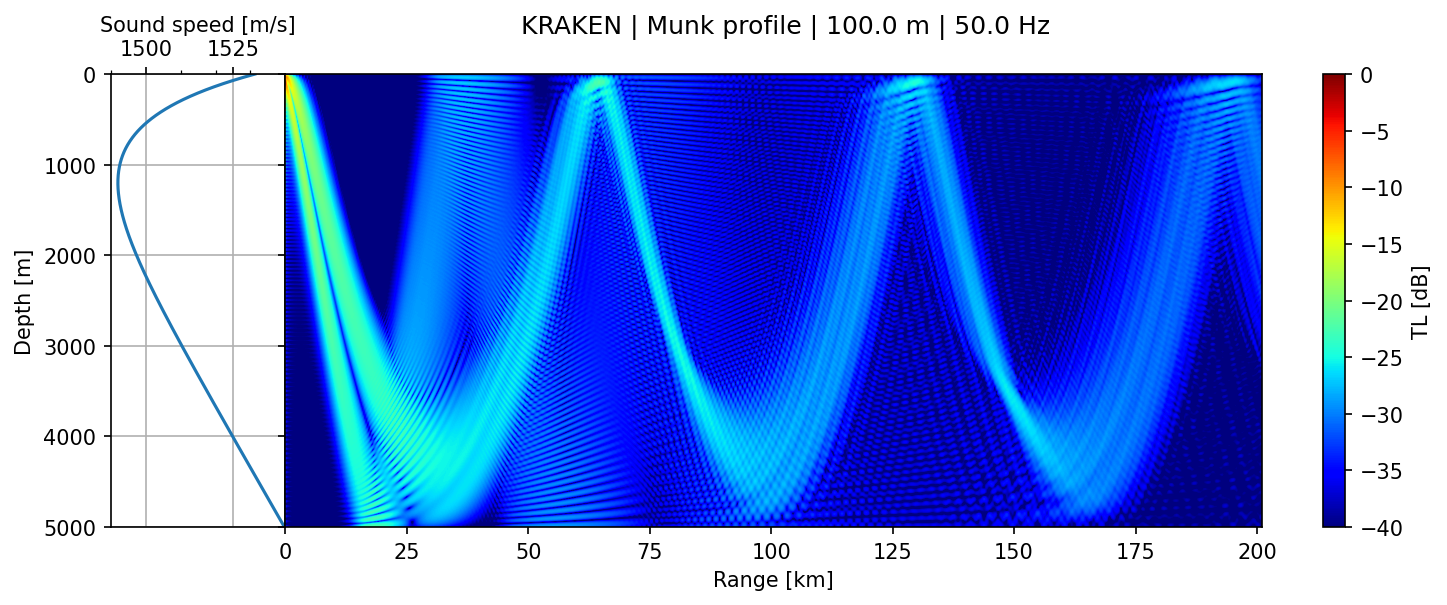

In [6]:
from tritonoa.at.models.kraken import runner

ssp_data = munk_ssp(5000, 5)
z_data = ssp_data["z"]
c_data = ssp_data["c_p"]

environment = {
    # 1. General
    "title": "Munk",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [
        {"z": z_data, "c_p": c_data, "rho": 1.0}
    ],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1600,
    "bot_rho": 1.8,
    "bot_a_p": 0.8,
    # 5. Speed constraints
    "clow": 0,
    "chigh": 1600,
    # 6. Receiver parameters
    "rec_z": np.arange(0, z_data.max() + 1, 5).tolist(),
    "rec_r": np.arange(0, 200 + 1, 10/1e3).tolist(),
    # "tilt": -1,
    # 7. Source parameters
    "src_z": 100.0,
    "freq": 50.0,
}

p = runner.run_kraken(environment)
p = normalize_pressure(p, log=True)

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(12, 4), dpi=150)

ax = plot_SSP(
    z_data,
    c_data,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax = plot_TL_2d(
    p,
    z=np.array(environment["rec_z"]),
    r=np.array(np.concatenate((np.array([0]), environment["rec_r"]))),
    xlabel="Range [km]",
    clabel="TL [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"{environment['model']} | {environment['title']} profile | {environment['src_z']} m | {environment['freq']} Hz")
plt.show()

## SWELLEX

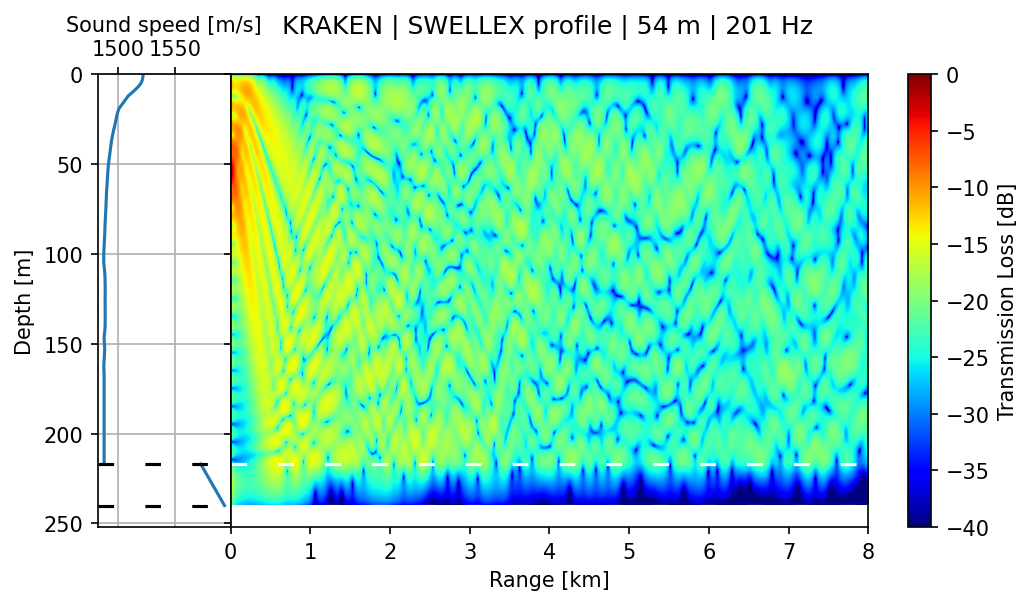

In [24]:
profile = "SWELLEX"
title = profile

fname = Path("/Users/williamjenkins/Research/Projects/BOGP/Data/SWELLEX96/CTD/i9606.prn")
z_data, c_data, _ = read_ssp(fname, 0, 3, header=None)
z_data = np.append(z_data, 217)
c_data = np.append(c_data, c_data[-1])


top = Top()

# ssp1 = SoundSpeedProfile(z=[0, 217], c_p=[1521.95, 1482], rho=1.)
ssp1 = SoundSpeedProfile(z=z_data, c_p=c_data, rho=1.)
ssp2 = SoundSpeedProfile(z=[217, 240], c_p=[1572.37, 1593.02], rho=1.8, a_p=0.3)
ssp3 = SoundSpeedProfile(z=[240, 1040], c_p=[1881, 3245.8], rho=2.1, a_p=0.09)
layer1 = Layer(ssp1)
layer2 = Layer(ssp2)
layer3 = Layer(ssp3)
layers = [layer1, layer2, layer3]

bottom = Bottom(opt="A", z=layer3.z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(54)
zvec = np.arange(0, layer2.z_max, 0.5)
dr = 0.5e-3
rvec = np.arange(dr, 8+dr, dr)
receiver = Receiver(zvec, rvec, tilt=2)

freq = 201
clow = 0
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKEN"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 6], "wspace": 0}, figsize=(8, 4), dpi=150)

z = np.array([])
c = np.array([])
b = np.array([])
for layer in layers[:-1]:
    z = np.concatenate((z, layer.ssp.z))
    c = np.concatenate((c, layer.ssp.c_p))
    b = np.concatenate((b, [layer.z_max]))

ax = plot_SSP(
    z,
    c,
    boundaries=b,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axs[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=b,
    xlabel="Range [km]",
    clabel="Transmission Loss [dB]",
    vmin=-40,
    ax=axs[1]
)
fig.suptitle(f"{model} | {profile} profile | {kmodel.source.z.item()} m | {freq} Hz")
plt.show()

In [25]:
delays = receiver.r_offsets / 1500
receiver.r_offsets
# l = 1500 / 201
# l

array([[8.35842946],
       [8.34097971],
       [8.32352996],
       [8.30608022],
       [8.28863047],
       [8.27118072],
       [8.25373097],
       [8.23628122],
       [8.21883147],
       [8.20138173],
       [8.18393198],
       [8.16648223],
       [8.14903248],
       [8.13158273],
       [8.11413298],
       [8.09668323],
       [8.07923349],
       [8.06178374],
       [8.04433399],
       [8.02688424],
       [8.00943449],
       [7.99198474],
       [7.974535  ],
       [7.95708525],
       [7.9396355 ],
       [7.92218575],
       [7.904736  ],
       [7.88728625],
       [7.86983651],
       [7.85238676],
       [7.83493701],
       [7.81748726],
       [7.80003751],
       [7.78258776],
       [7.76513802],
       [7.74768827],
       [7.73023852],
       [7.71278877],
       [7.69533902],
       [7.67788927],
       [7.66043953],
       [7.64298978],
       [7.62554003],
       [7.60809028],
       [7.59064053],
       [7.57319078],
       [7.55574104],
       [7.538

## Arctic Ocean

In [5]:
profile = "FramStrait"
title = profile

z_BT, cp_BT, _ = read_ssp("XBT.csv", 0, 1, header=0)

# Top halfspace properties
top = Top(opt="CVW    ")
# Ice properties
z_ice = 2
ssp1 = SoundSpeedProfile(z=[0, z_ice], c_p=3880, c_s=1888, rho=0.920, a_p=0.1656, a_s=0.4835)
layer1 = Layer(ssp1)

# Water properties
mask = z_BT > z_ice
z_BT = z_BT[mask]
cp_BT = cp_BT[mask]
ssp2 = SoundSpeedProfile(z=z_BT, c_p=cp_BT, rho=1.025, a_p=6.5e-5)
layer2 = Layer(ssp2)

# Sediment properties
ssp3 = SoundSpeedProfile(z=[layer2.z_max, layer2.z_max + 50], c_p=1650, rho=1.5, a_p=0.4)
layer3 = Layer(ssp3)

# Bottom properties
layers = [layer1, layer2, layer3]
bottom = Bottom(opt="A", z=layer3.z_max, c_p=4500, rho=2., a_p=0.4)
# layers = [layer1, layer2]
# bottom = Bottom(opt="A", z=layer2.z_max, c_p=4500, rho=2., a_p=0.4)

source = Source(10.5)
zvec = np.arange(0, bottom.z, 1)
dr = 1e-3
rvec = np.arange(dr, 20+dr, dr)
receiver = Receiver(zvec, rvec)

freq = 200
clow = 1400
chigh = 1600

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)


fig = plt.figure(figsize=(8, 6), dpi=150)
subfigs = fig.subfigures(2, 1, wspace=0.7)

axsTop = subfigs[0].subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0})

# fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0}, figsize=(8, 3), dpi=150)
ax = plot_SSP(
    layer2.ssp.z,
    layer2.ssp.c_p,
    boundaries=layer2.z_max,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axsTop[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=layer2.z_max,
    xlabel="Range [km]",
    clabel="TL [dB]",
    # title=f"{model} | {profile} profile | {kmodel.source.z} m | {freq} Hz",
    vmin=-40,
    ax=axsTop[1],
    cmap="jet"
)


dr = 0.1
rvec = np.arange(dr, 100+dr, dr)
receiver = Receiver(zvec, rvec)

kmodel = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)
model = "KRAKENC"
kmodel.run(fldflag=True, model=model)
p = normalize_pressure(kmodel.modes.p, log=True)

axsBot = subfigs[1].subplots(1, 2, sharey=True, gridspec_kw={"width_ratios": [1, 7], "wspace": 0})
ax = plot_SSP(
    layer2.ssp.z,
    layer2.ssp.c_p,
    boundaries=layer2.z_max,
    xlabel="Sound speed [m/s]",
    ylabel="Depth [m]",
    ax=axsBot[0]
)
ax = plot_TL_2d(
    p,
    z=kmodel.receiver.z,
    r=np.concatenate((np.array([0]), kmodel.receiver.r)),
    boundaries=layer2.z_max,
    xlabel="Range [km]",
    clabel="TL [dB]",
    # title=f"{model} | {profile} profile | {kmodel.source.z} m | {freq} Hz",
    vmin=-30,
    ax=axsBot[1],
    cmap="jet"
)
fig.suptitle(f"Source: {kmodel.source.z.item()} m, {freq} Hz")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'XBT.csv'